In [28]:
import Pkg; 

if split(pwd(),"/")[end] == "notebooks"
    cd(joinpath(@__DIR__, "../"))
    Pkg.activate("Project.toml")
end

using MorphoMol

using CairoMakie
using LinearAlgebra
using Random
using Rotations
using StaticArrays

In [29]:
Rt = exp(Rotations.RotationVecGenerator((rand(3) .* pi)...))

3×3 RotationVec{Float64} with indices SOneTo(3)×SOneTo(3)(0.907302, 1.25786, 2.71394):
 -0.831387   0.219918  0.510326
  0.247261  -0.676033  0.694148
  0.497652   0.703289  0.507667

In [30]:
vs = [1,2,3]
ws = [4,5,6]

zip(vs,ws) |> collect

3-element Vector{Tuple{Int64, Int64}}:
 (1, 4)
 (2, 5)
 (3, 6)

In [8]:
function chained_rotation_gradient(∇E,R,v,w)
    ∇E[1] = 0.5 * (-v[2]*(R[3,:] ⋅ w) + v[3]*(R[2,:] ⋅ w))
    ∇E[2] = 0.5 * (v[1]*(R[3,:] ⋅ w) - v[3]*(R[1,:] ⋅ w))
    ∇E[3] = 0.5 * (-v[1]*(R[2,:] ⋅ w) + v[2]*(R[1,:] ⋅ w))
    ∇E
end

#vs gradients of the energy function
#ws template coordinates
function rotation_and_translation_gradient(∇E,R,vs,ws)
    ∇E[1] = 0.5 * sum([-v[2]*(R[3,:] ⋅ w) + v[3]*(R[2,:] ⋅ w) for v,w in zip(vs,ws)])
    ∇E[2] = 0.5 * sum([v[1]*(R[3,:] ⋅ w) - v[3]*(R[1,:] ⋅ w) for v,w in zip(vs,ws)])
    ∇E[3] = 0.5 * sum([-v[1]*(R[2,:] ⋅ w) + v[2]*(R[1,:] ⋅ w) for v,w in zip(vs,ws)])
    #TODO is this right?
    ∇E[4:6] = sum(vs)
    ∇E
end

chained_rotation_gradient (generic function with 1 method)

In [9]:
# v = direction of maximum energy
# w = initial state
function rotating_needle_energy(R, v, w)
    v ⋅ (R * w)
end

# Same as above!
function rotating_needle_energy_gradient!(∇E, R, v, w)
    ∇E[1] = 0.5 * (w[1]*(v[3]*R[2,1] - v[2] * R[3,1]) + w[2]*(v[3]*R[2,2] - v[2] * R[3,2]) + w[3]*(v[3]*R[2,3] - v[2] * R[3,3]))
    ∇E[2] = 0.5 * (w[1]*(v[1]*R[3,1] - v[3] * R[1,1]) + w[2]*(v[1]*R[3,2] - v[3] * R[1,2]) + w[3]*(v[1]*R[3,3] - v[3] * R[1,3]))
    ∇E[3] = 0.5 * (w[1]*(v[2]*R[1,1] - v[1] * R[2,1]) + w[2]*(v[2]*R[1,2] - v[1] * R[2,2]) + w[3]*(v[2]*R[1,3] - v[1] * R[2,3]))
    ∇E
end

rotating_needle_energy_gradient! (generic function with 1 method)

In [14]:
chained_rotation_gradient([0.0, 0.0, 0.0], Rt, v, w)

3-element Vector{Float64}:
 -0.0
 -0.4194795826613064
 -0.04977628161125636

In [15]:
rotating_needle_energy_gradient!([0.0, 0.0, 0.0], Rt, v, w)

3-element Vector{Float64}:
  0.0
 -0.4194795826613064
 -0.04977628161125636

In [26]:
T = 0.2
ε = 0.1
p = [0.0, 0.0, 0.0]
L = 50
β = 1.0 / T

σ = 1.0
draw_perturbation! = (p) -> for i in 1:length(p) p[i] = σ * randn(eltype(p)) end
inner_product = (p) -> p ⋅ p

v = [1.0, 0.0, 0.0] # direction of maximum energy
w = [0.0, 1.0, 0.0] # initial state

energy(R) = rotating_needle_energy(R, v, w)
#energy_gradient!(∇E, R) = rotating_needle_energy_gradient!(∇E, R, v, w)
energy_gradient!(∇E, R) = chained_rotation_gradient(∇E, R, v, w)
exponential_map(eps_p) = exp(Rotations.RotationVecGenerator((eps_p)...))

hmc = MorphoMol.Algorithms.HamiltonianMonteCarlo(energy, energy_gradient!, inner_product, draw_perturbation!, exponential_map, β, L, ε)
R = exp(Rotations.RotationVecGenerator((rand(3) .* pi)...))
p = [0.0, 0.0, 0.0]
iterations = 100000
states, accepted_steps = MorphoMol.Algorithms.simulate!(hmc, R, p, iterations);
state_coordinates = [R * [0.0, 1.0, 0.0] for R in states]
xs = [c[1] for c in state_coordinates]
ys = [c[2] for c in state_coordinates]
zs = [c[3] for c in state_coordinates];
accepted_steps / iterations

0.80977

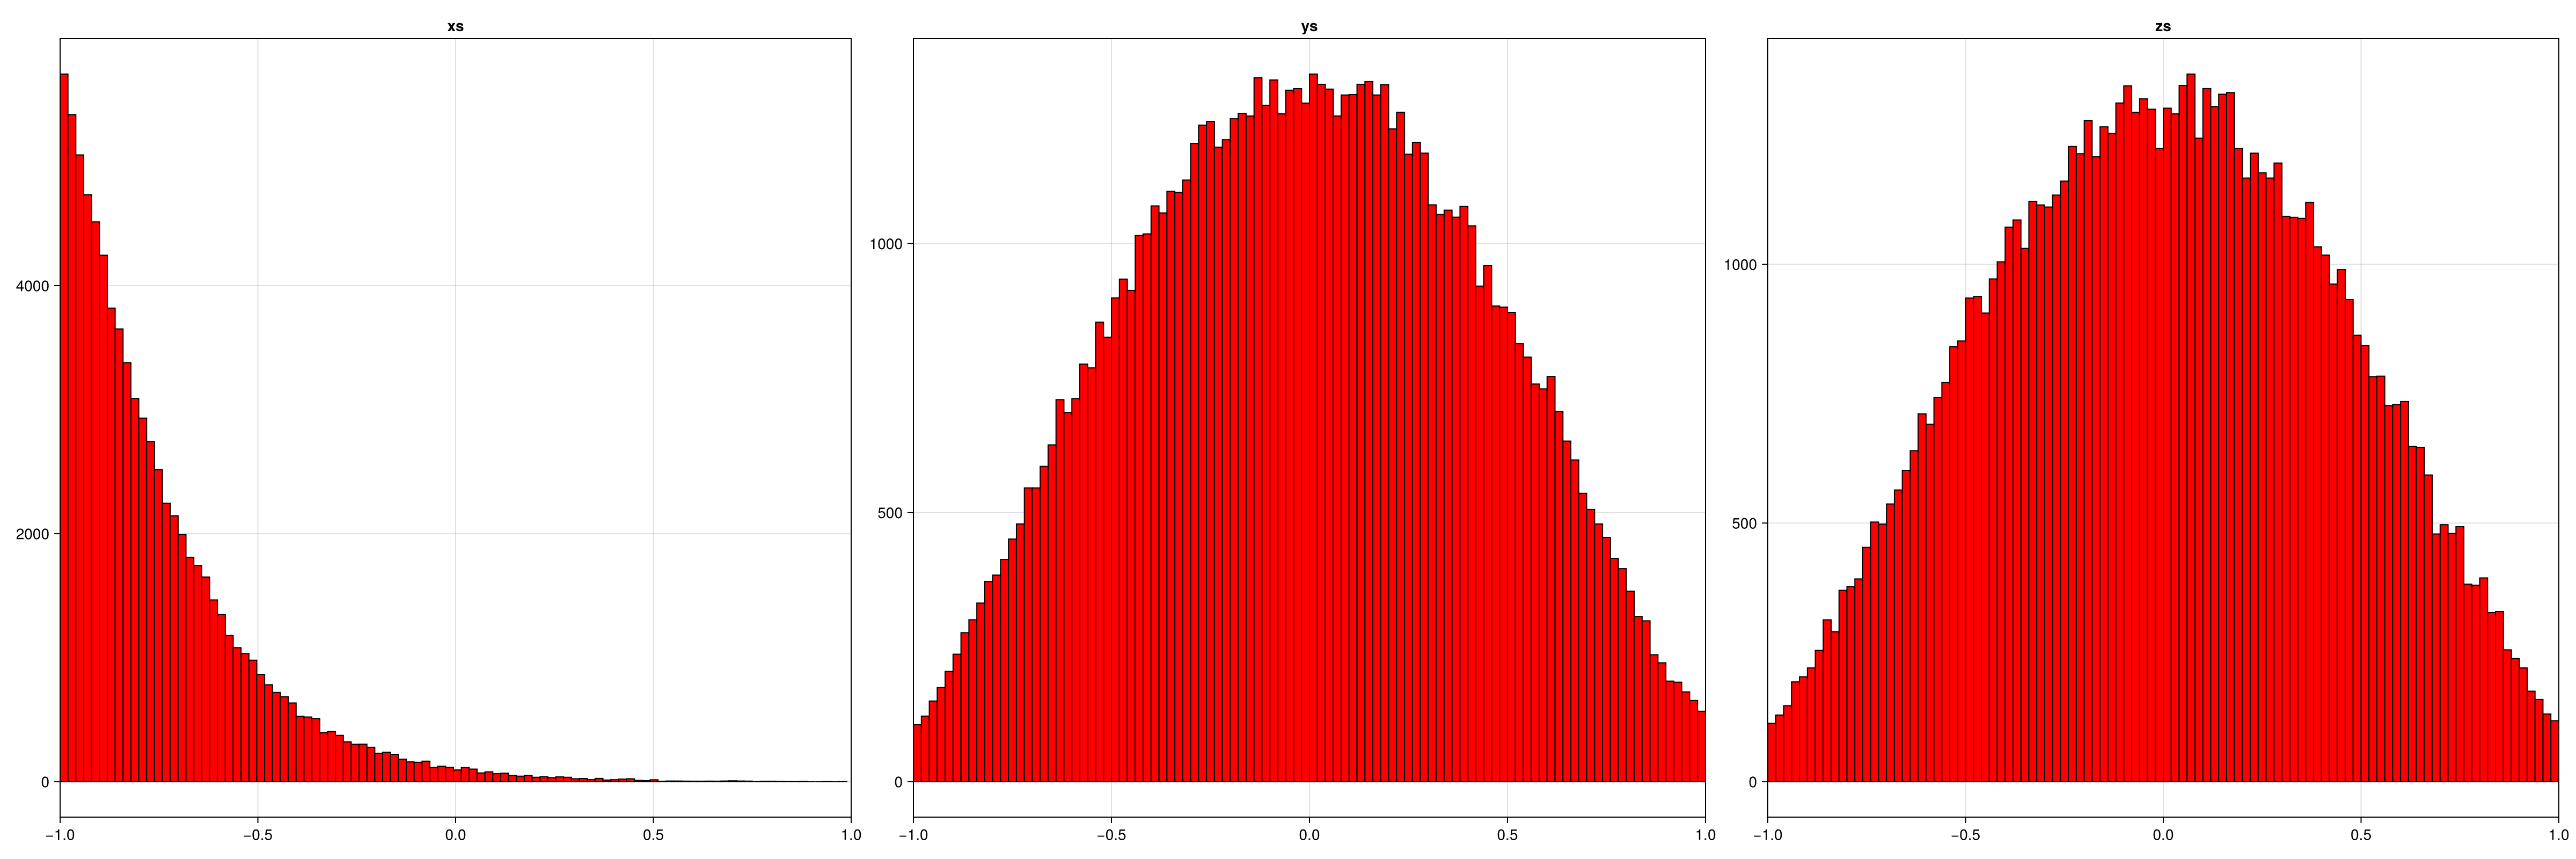

In [27]:
f = Figure(size = (2400, 800))
bin_number = 100
hist(f[1, 1], xs, bins = bin_number, color = :red, strokewidth = 1, strokecolor = :black, axis = (title = "xs", limits = ((-1.0, 1.0), nothing),))
hist(f[1, 2], ys, bins = bin_number, color = :red, strokewidth = 1, strokecolor = :black, axis = (title = "ys", limits = ((-1.0, 1.0), nothing),))
hist(f[1, 3], zs, bins = bin_number, color = :red, strokewidth = 1, strokecolor = :black, axis = (title = "zs", limits = ((-1.0, 1.0), nothing),))
f